## Installation and Requirements

In [1]:
# !pip install qc-grid
# !pip install qc-atomdb

In [1]:
# Import required libraries
import numpy as np
from functools import lru_cache

from grid.onedgrid import Trapezoidal
from grid.rtransform import LinearFiniteRTransform
from grid.utils import convert_cart_to_sph, generate_real_spherical_harmonics
from grid.becke import BeckeWeights
from grid import AtomGrid
from atomdb import make_promolecule

import matplotlib.pyplot as plt

In [8]:
# Function to generate the vertices of a regular icosahedron
def icosahedron_vertices():
    # Golden ratio
    phi = (1 + np.sqrt(5)) / 2

    # Normalize the length to 1
    a = 1 / np.sqrt(1 + phi ** 2)
    b = phi * a

    # Vertices of an icosahedron
    vertices = [
        (-a, b, 0), (a, b, 0), (-a, -b, 0), (a, -b, 0),
        (0, -a, b), (0, a, b), (0, -a, -b), (0, a, -b),
        (b, 0, -a), (b, 0, a), (-b, 0, -a), (-b, 0, a)
    ]
    return np.array(vertices)


# Function to subdivide the faces of an icosahedron
def subdivide(vertices, faces):
    # New vertex set, including old vertices
    new_vertices = vertices.tolist()
    vertex_map = {}

    # Helper function to find the midpoint and index
    def midpoint_index(v1, v2):
        # Check if we have already calculated this
        edge = tuple(sorted([v1, v2]))
        if edge in vertex_map:
            return vertex_map[edge]

        # Calculate midpoint and normalize it to the sphere
        midpoint = (vertices[v1] + vertices[v2]) / 2
        midpoint /= np.linalg.norm(midpoint)

        # Store the new vertex index
        index = len(new_vertices)
        new_vertices.append(midpoint)
        vertex_map[edge] = index
        return index

    new_faces = []

    for v1, v2, v3 in faces:
        # Get the midpoints
        a = midpoint_index(v1, v2)
        b = midpoint_index(v2, v3)
        c = midpoint_index(v3, v1)

        # Create four new faces
        new_faces.extend([
            [v1, a, c],
            [v2, b, a],
            [v3, c, b],
            [a, b, c]
        ])

    return np.array(new_vertices), np.array(new_faces)


# Function to generate an icosphere with a specified number of subdivisions
def generate_icosphere(subdivisions):
    # Initial icosahedron vertices and faces
    vertices = icosahedron_vertices()
    faces = [
        [0, 11, 5], [0, 5, 1], [0, 1, 7], [0, 7, 10], [0, 10, 11],
        [1, 5, 9], [5, 11, 4], [11, 10, 2], [10, 7, 6], [7, 1, 8],
        [3, 9, 4], [3, 4, 2], [3, 2, 6], [3, 6, 8], [3, 8, 9],
        [4, 9, 5], [2, 4, 11], [6, 2, 10], [8, 6, 7], [9, 8, 1]
    ]

    # Subdivide the triangles the number of times specified
    for _ in range(subdivisions):
        vertices, faces = subdivide(vertices, faces)

    return vertices



# Function to calculate integration weights for grid points
def calculate_weights(points):
    # Convert cartesian coordinates to spherical coordinates
    sph_points = convert_cart_to_sph(points)
    r, theta, phi = sph_points.T
    n_points = len(points)
    l_max = (np.sqrt(n_points) - 1).astype(int)

    # Generate real spherical harmonics
    spherical_harmonics = generate_real_spherical_harmonics(l_max, theta, phi)
    n_spherical_harmonics = len(spherical_harmonics)

    # Set up the right-hand side of the equation
    b = np.zeros(n_spherical_harmonics)
    b[0] = np.sqrt(4 * np.pi)

    # Solve the least squares problem to find weights
    w_sphere, _, _, s = np.linalg.lstsq(spherical_harmonics.astype(np.float64), b)

    return w_sphere

# Function to generate an angular grid from an icosphere with caching for efficiency
# def angular_grid_from_icosphere(subdivisions):
#     # Generate the icosphere
#     vertices, faces = generate_icosphere(subdivisions)
#     points = vertices

#     # Calculate the weights for the grid points
#     weights = calculate_weights(points)

#     # Set up the grid
#     grid = AtomGrid()
#     grid.points = points
#     grid.weights = weights
#     grid.faces = faces
#     return grid

@lru_cache(maxsize=None)
def angular_grid_from_icosphere(icosphere_order):

    points = generate_icosphere(icosphere_order)
    # print("\n\tGenerated Icosphere Points:", points.shape)
    # print("\n\tGenerated Icosphere Points:", points)

    w_sphere = calculate_weights(points)
    # print("\tGenerated Icosphere Weights:", w_sphere.shape)
    # print("\tGenerated Icosphere Weights:", w_sphere)
    return points, w_sphere



# Functions for DFT calculations

# Calculate Fermi wave vector
def k_f(dens_point):
    kf = (dens_point * 3 * np.pi ** 2) ** (1 / 3)
    return kf

# Calculate the exchange energy density
def eps_x(dens_point):
    e_val = 1
    kf = k_f(dens_point)
    eps_x = -3 * kf * e_val**2 / (4 * np.pi)
    return eps_x

# Calculate dimensionless density gradient
def dimless_dens_grad(dens_point, grad_point):
    kf = k_f(dens_point)
    s = grad_point / (2 * kf * dens_point)
    return s

# Calculate enhancement factor for PBE exchange functional
def f_x(dens_point, grad_point):
    kappa = 0.8040
    mu = 0.2195149727645171
    s = dimless_dens_grad(dens_point, grad_point)
    fx = 1 + kappa - kappa / (1 + (mu / kappa) * s ** 2)
    return fx

# Calculate the exchange energy
def e_x(dens_point, grad_point):
    epsx = eps_x(dens_point)
    fx = f_x(dens_point, grad_point)
    ex = epsx * fx * dens_point
    return ex


# Helper function to normalize vectors
def unit_v(vector):
    return vector / np.linalg.norm(vector, axis=1, keepdims=True)


atcoords = np.array([[0, 0, 0]])
atnums = np.array([10]) # Atomic number of neon is 10
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')


# Calculate density gradient gradient
def dens_grad_grad(grid):
    dd_dens_norm = promol.atoms[0].dd_dens_func()(np.linalg.norm(grid, axis=1))
    return dd_dens_norm[:, None] * unit_v(grid)


# Helper function for exchange potential calculation
def alg(grad_vec, dens_grad_grad):
    a = grad_vec * dens_grad_grad
    return a.sum(axis=1)


# Calculate derivative of enhancement factor
def d_f_x(dens_point, grad_point):
    kappa = 0.8040
    mu = 0.2195149727645171
    s = dimless_dens_grad(dens_point, grad_point)
    dfx = 2 * kappa ** 2 * mu * s / (kappa + mu * s ** 2) ** 2
    return dfx


# Calculate second derivative of enhancement factor
def dd_f_x(dens_point, grad_point):
    kappa = 0.8040
    mu = 0.2195149727645171
    s = dimless_dens_grad(dens_point, grad_point)
    b = mu * s ** 2 / kappa + 1
    ddfx = -kappa * (8 * mu ** 2 * s ** 2 / (kappa ** 2 * b ** 3) - 2 * mu / (kappa * b ** 2))
    return ddfx

# Calculate exchange potential
def v_x(dens_point, grad_point, lap_point, grad_vec, dens_grad_grad):
    s = dimless_dens_grad(dens_point, grad_point)
    fx = f_x(dens_point, grad_point)
    kf = k_f(dens_point)
    algo = alg(grad_vec, dens_grad_grad)
    dfx = d_f_x(dens_point, grad_point)
    ddfx = dd_f_x(dens_point, grad_point)

    a_x = -3 * (3 * np.pi ** 2) ** (1 / 3) / (4 * np.pi)

    vx = a_x * dens_point ** (1 / 3) * (4 * fx / 3 +
                                        (-4 / 3 * s - (
                                            1 / (2 * kf) * lap_point / grad_point) + 1 / (
                                             2 * kf) * algo / (
                                             grad_point ** 2)) * dfx +
                                        (-1 / (2 * kf) ** 2 * algo / (
                                            grad_point * dens_point) + 4 / 3 * s ** 2) * ddfx)
    return vx




# Functions to calculate different variables at grid points

# Calculate electron density at grid points
def calc_num_e(promol, points):
    return promol.density(points)


# Calculate exchange energy at grid points
def calc_e_x(promol, points):
    dens = promol.density(points)
    dens_grad = promol.gradient(points)
    dens_grad_norm = np.linalg.norm(dens_grad, axis=1)
    return e_x(dens, dens_grad_norm)


# Calculate exchange potential at grid points
def calc_v_x(promol, points):
    dens = promol.density(points)
    dens_grad = promol.gradient(points)
    dens_grad_norm = np.linalg.norm(dens_grad, axis=1)
    dens_lap = promol.laplacian(points)
    dens_gradgrad = dens_grad_grad(points)
    vx = v_x(dens, dens_grad_norm, dens_lap, dens_grad, dens_gradgrad)
    return vx


In [9]:
# Global list to save the calculated points, weights, and differences
global_xc_list = []
global_wc_list = []
global_diff_list = []


def adaptive_recursive_fn(xi, xf, promol,
                        thresh=1,
                        variable='num_electrons',
                        onedgrid_fn=Trapezoidal,
                        radialgrid_fn=LinearFiniteRTransform):

    print(f"\nCalculating adaptive grid for [{xi}, {xf}]")
    print("promol:", promol)

    match variable:
        case "num_electrons":
            calc_variable = calc_num_e
            tol = 1e-15


    atnum = promol.atoms[0]._data.atnum
    atcoord = promol.coords[0]


    # 2-point grid
    onedgrid_2 = onedgrid_fn(npoints = 2)
    radial_grid_2 = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_2)
    angular_grid_2 = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid_2,
        center=atcoord
    )
    dens_test_2 = promol.density(angular_grid_2.points)
    val_ref_integrand_2 = calc_variable(promol, angular_grid_2.points)
    val_ref_2 = np.nansum(val_ref_integrand_2 * angular_grid_2.weights)
    print(f"\n2 Points Angular Value: {val_ref_2}")


    # 3-point grid
    onedgrid_3 = onedgrid_fn(npoints = 3)
    radial_grid_3 = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_3)
    angular_grid_3 = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid_3,
        center=atcoord
    )
    dens_test_3 = promol.density(angular_grid_2.points)
    val_ref_integrand_3 = calc_variable(promol, angular_grid_3.points)
    val_ref_3 = np.nansum(val_ref_integrand_3 * angular_grid_3.weights)
    print(f"3 Points Angular Value: {val_ref_3}")

    # N-point grid only to see the more accurate results, not used in the algorithm. Here, N = 100
    onedgrid_N = onedgrid_fn(npoints = 100)
    radial_grid_N = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_N)
    angular_grid_N = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid_N,
        center=atcoord
    )
    dens_test_N = promol.density(angular_grid_N.points)
    val_ref_integrand_N = calc_variable(promol, angular_grid_N.points)
    val_ref_N = np.nansum(val_ref_integrand_N * angular_grid_N.weights)
    print(f"N Points Angular Value: {val_ref_N}")

    # Obtain the center point and weight to further range subdivision. Index [1] used because it's the midpoint from [0,1,2] in 3-points grid
    xc = radial_grid_3.points[1]
    wc = radial_grid_3.weights[1]

    # Calculate the difference
    diff = abs(val_ref_2 - val_ref_3)

    # Save and print the value
    global_xc_list.append(xc)
    global_wc_list.append(wc)
    global_diff_list.append(diff)
    print(f"xc: {xc}, wc: {wc}")
    print(f"diff: {diff}")
    # print(global_xc_list)
    # print(global_wc_list)

    if diff < thresh:
        return diff
    else:
        # Continue recursively
        return {
            "left": adaptive_recursive_fn(xi, xc, promol, thresh, variable, onedgrid_fn, radialgrid_fn),
            "right": adaptive_recursive_fn(xc, xf, promol, thresh, variable, onedgrid_fn, radialgrid_fn)
        }

In [10]:
x_i = 0
x_f = 10

atcoords = np.array([[0, 0, 0]])
atnums = np.array([10])  # Atomic number 10 is neon
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')


# Add initial point x_i and x_f to the global list
radial_grid_0 = LinearFiniteRTransform(x_i, x_f).transform_1d_grid(Trapezoidal(npoints=2))
global_xc_list.extend(radial_grid_0.points[:2])
global_wc_list.extend(radial_grid_0.weights[:2])

# Run the main adaptive recursive radial function
diff_log = adaptive_recursive_fn(0, 10, promol=promol, thresh=0.0001)


Calculating adaptive grid for [0, 10]
promol: <atomdb.promolecule.Promolecule object at 0x7f7580781700>

2 Points Angular Value: 2.7195041513369354e-08
3 Points Angular Value: 0.0038419706451591463
N Points Angular Value: 9.901472339141483
xc: 5.0, wc: 5.0
diff: 0.003841943450117633

Calculating adaptive grid for [0, 5.0]
promol: <atomdb.promolecule.Promolecule object at 0x7f7580781700>

2 Points Angular Value: 0.0019209785238191949
3 Points Angular Value: 0.6311406282125602


/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)


N Points Angular Value: 9.991894679178257
xc: 2.5, wc: 2.5
diff: 0.629219649688741

Calculating adaptive grid for [0, 2.5]
promol: <atomdb.promolecule.Promolecule object at 0x7f7580781700>

2 Points Angular Value: 0.31509006947532536
3 Points Angular Value: 4.862602439403497
N Points Angular Value: 9.889138170107728
xc: 1.25, wc: 1.25
diff: 4.547512369928171

Calculating adaptive grid for [0, 1.25]
promol: <atomdb.promolecule.Promolecule object at 0x7f7580781700>

2 Points Angular Value: 2.3525287023329167
3 Points Angular Value: 6.146622876472291
N Points Angular Value: 8.210898541668227
xc: 0.625, wc: 0.625
diff: 3.7940941741393743

Calculating adaptive grid for [0, 0.625]
promol: <atomdb.promolecule.Promolecule object at 0x7f7580781700>

2 Points Angular Value: 2.4851792626529168
3 Points Angular Value: 2.8543973531857123
N Points Angular Value: 4.328208502446685
xc: 0.3125, wc: 0.3125
diff: 0.36921809053279553

Calculating adaptive grid for [0, 0.3125]
promol: <atomdb.promolecule.P

radial grid: (1000,)


0.0
0.008346647529045436
0.026811658853030777
0.04847936636546242
0.06931252432657932
0.08716990991597623
0.10112536413318642
0.11100210521764381
0.11705921035378362
0.11978460612549682
0.11976184940446319
0.11758744774660809
0.11382232269275248
0.10896594174059727
0.10344515615032562
0.09761227182741071
0.09174863631613903
0.08607125559056307
0.08074081109978168
0.07587003918181878
0.0715318394200063
0.06776675137299042
0.06458961997731304
0.06199538688777362
0.059964018017744224
0.058464620567659595
0.05745882580780161
0.05690352365115177
0.05675303642234213
0.05696081550076486
0.057480737855694075
0.05826807147313983
0.059280170174132285
0.06047695000890118
0.061821191607751895
0.0632787057871678
0.06481839340260562
0.06641222495028619
0.06803516069669344
0.06966502808860346
0.07128236982694959
0.07287027316634231
0.0744141886812205
0.07590174483317301
0.07732256312510646
0.07866807738292733
0.07993135970400445
0.08110695482594552
0.08219072404435564
0.08317969933212971
0.0840719479

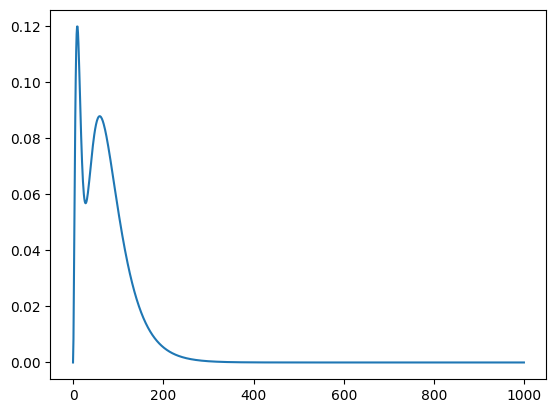

In [11]:
xi = 0
xf = 11

atcoords = np.array([[0, 0, 0]])
atnums = np.array([10])  # Atomic number 10 is neon
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')

atnum = promol.atoms[0]._data.atnum
atcoord = promol.coords[0]


onedgrid = Trapezoidal(npoints = 1000)
radial_grid = LinearFiniteRTransform(xi, xf).transform_1d_grid(onedgrid)
print("radial grid:", radial_grid.points.shape)
angular_grid = AtomGrid.from_preset(
    atnum=atnum,
    preset='fine',
    rgrid=radial_grid,
    center=atcoord
)

density_list = []
idx = angular_grid._indices
for i in range(len(idx)-1):
    dens = calc_num_e(promol, angular_grid.points[idx[i]:idx[i+1]])
    weights = angular_grid.weights[idx[i]:idx[i+1]]
    val = np.nansum(dens * weights)
    density_list.append(val)
    print(val)

print(density_list)
print(sum(density_list))

dens_full = calc_num_e(promol, angular_grid.points)
print(np.nansum(dens_full * angular_grid.weights))

plt.plot(density_list)

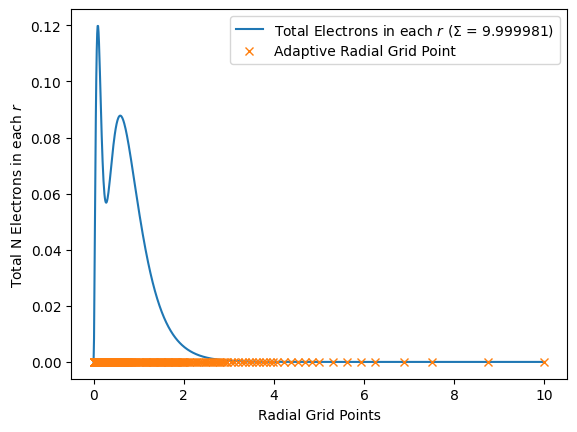

In [12]:
sum_e = np.sum(density_list)
r_values = np.linspace(0, 10, 1000)
plt.plot(r_values, density_list, label=f'Total Electrons in each $r$ (Σ = {sum_e:.6f})')
plt.plot(global_xc_list, np.repeat(0, len(global_xc_list)), 'x', markersize=6, label='Adaptive Radial Grid Point')
plt.ylabel(f"Total N Electrons in each $r$")
plt.xlabel("Radial Grid Points")
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
# Function to create an adaptive grid for numerical integration
def adaptive_grid(promol, variable, radial_grid):
    # Select the appropriate calculation function and tolerance based on the variable
    match variable:
        case "num_electrons":
            calc_variable = calc_num_e
            tol = 1e-15
        case "energy":
            calc_variable = calc_e_x
            tol = 1e-15
        case "potential":
            calc_variable = calc_v_x
            tol = 1e-4
        case _:
            raise ValueError("Invalid variable name, can only be one of 'num_electrons', 'energy', or 'potential'")



    # Generate radial grid
    # oned_grid = Trapezoidal(npoints=100)
    # print("\nOne Dimensional Grid Points:", oned_grid.points)
    # print("One Dimensional Grid Weights:", oned_grid.weights)
    # plt.scatter(oned_grid.points, np.repeat(0, oned_grid.size), marker='o')

    # radial_grid = LinearFiniteRTransform(0.0, 15).transform_1d_grid(oned_grid)
    # print("\nRadial Grid Points:", radial_grid.points)
    # print("Radial Grid Integration with (1):", radial_grid.integrate(np.repeat(1, radial_grid.size)))
    # print("Radial Grid Dot Product:", np.sum(np.dot(radial_grid.weights, 1)))



    # Generate initial angular grid and compute the weights
    points, w_sphere = angular_grid_from_icosphere(0)
    # print("\nInitial Angular Grid Shape:", points.shape)
    # print("\nAngular Grid Points[0]:", points[0])
    # print("Initial Angular Grid Weights:", w_sphere.shape)
    # print("\nAngular Grid Points:", points)

    icosphere_orders = np.zeros(len(radial_grid.points), dtype=np.int64)
    grid = np.concatenate([x * points for x in radial_grid.points])

    # print("\nAngular Grid Weights:", w_sphere)
    # print("Grid Points Shape:", grid.shape, "<- Radial Grid Points:", radial_grid.points.shape[0], "x", points.shape[0])

    # print("Icosphere Orders:", icosphere_orders)
    # print("\Grid:", grid)




    # Obtain Becke weights and calculate the total weights
    ws = BeckeWeights().compute_weights(points=grid, atcoords=atcoords, atnums=atnums)

    weights = np.concatenate(
        [w * w_sphere * p ** 2 for w, p in zip(radial_grid.weights, radial_grid.points)]
    )
    mol_weights = weights * ws

    # print("\nBecke Weights:", ws.shape)
    # print("Weights:", weights.shape)
    # Calculate the variable at each point and integrate
    val_0_integrand = calc_variable(promol, grid)
    val_0 = np.nansum(val_0_integrand * mol_weights)

    # ------------------------------ ITERATIONS AT EACH POINT OF R ------------------------------
    max_iter = 5



    # Create a reference grid for comparison
    atnum = promol.atoms[0]._data.atnum
    atcoord = promol.coords[0]
    reference_grid = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid,
        center=atcoord
    )
    dens_test = promol.density(reference_grid.points)
    val_ref_integrand = calc_variable(promol, reference_grid.points)
    val_ref = np.nansum(val_ref_integrand * reference_grid.weights)

    # print("\n\n### Referene Grid")
    # print(f'{variable}: {val_ref:.6f}')

    # If initial grid is already accurate enough, return the value
    if abs(val_ref - val_0) < tol:
        return grid, weights, icosphere_orders

    radial_weights = radial_grid.weights * radial_grid.points ** 2



    # Adaptive refinement for each radial point

    deltae_list = list()
    val_final = 0
    print("\n\n### Adaptive Refinement for each radial point")
    for i, (x, ws) in enumerate(zip(radial_grid.points, radial_weights)):
        # Start with lowest order angular grid
        print("\t# Radial Point:", x)
        points_o, weights_o = angular_grid_from_icosphere(0)
        weights = ws * weights_o
        radial_ox = points_o * x
        val_prev_integrand = calc_variable(promol, radial_ox)
        val_prev = np.nansum(val_prev_integrand * weights)

        # Increase angular resolution until convergence
        for order in range(1, max_iter):
            print("\t\t# Icosphere Order Iter:", order)
            points_o, weights_o = angular_grid_from_icosphere(order)
            weights = ws * weights_o
            radial_ox = points_o * x
            val_test_integrand = calc_variable(promol, radial_ox)
            val_test = np.nansum(val_test_integrand * weights)
            dval = abs(val_test - val_prev)
            if dval < tol:
              icosphere_orders[i] = order - 1
              deltae_list.append(dval)
              val_final += val_prev
              break
            else:
                val_prev = val_test
        else:
            # Reached max iterations without convergence -- use last highest order
            icosphere_orders[i] = order
            deltae_list.append(dval)
            val_final += val_test

    # Create final grid and weights using the determined icosphere orders
    grid = np.concatenate(
        [x * angular_grid_from_icosphere(o)[0] for x, o in zip(radial_grid.points, icosphere_orders)]
    )
    weights = np.concatenate(
        [w * angular_grid_from_icosphere(o)[1] * x ** 2 for w, x, o in zip(radial_weights, radial_grid.points, icosphere_orders)]
    )

    # Print results
    print("\n\nFinal Adaptive Refinement Results")
    print(f'{variable}: {val_final:.6f}')
    print(f'Difference from reference: {np.abs(val_final - val_ref):.6f}')
    print(f'Icosphere Orders: {icosphere_orders}')

    return grid, weights, icosphere_orders


In [14]:

print(global_xc_list)

ws = BeckeWeights().compute_weights(points=global_xc_list, atcoords=atcoords, atnums=atnums)

ws

[np.float64(0.0), np.float64(10.0), np.float64(5.0), np.float64(2.5), np.float64(1.25), np.float64(0.625), np.float64(0.3125), np.float64(0.15625), np.float64(0.078125), np.float64(0.0390625), np.float64(0.01953125), np.float64(0.009765625), np.float64(0.0048828125), np.float64(0.00244140625), np.float64(0.00732421875), np.float64(0.0146484375), np.float64(0.01220703125), np.float64(0.01708984375), np.float64(0.029296875), np.float64(0.05859375), np.float64(0.048828125), np.float64(0.0439453125), np.float64(0.04150390625), np.float64(0.04638671875), np.float64(0.0537109375), np.float64(0.05126953125), np.float64(0.05615234375), np.float64(0.068359375), np.float64(0.0634765625), np.float64(0.06103515625), np.float64(0.06591796875), np.float64(0.0732421875), np.float64(0.07080078125), np.float64(0.07568359375), np.float64(0.1171875), np.float64(0.09765625), np.float64(0.087890625), np.float64(0.0830078125), np.float64(0.08056640625), np.float64(0.08544921875), np.float64(0.0927734375), n

ValueError: operands could not be broadcast together with shapes (1,1,3) (243,) 

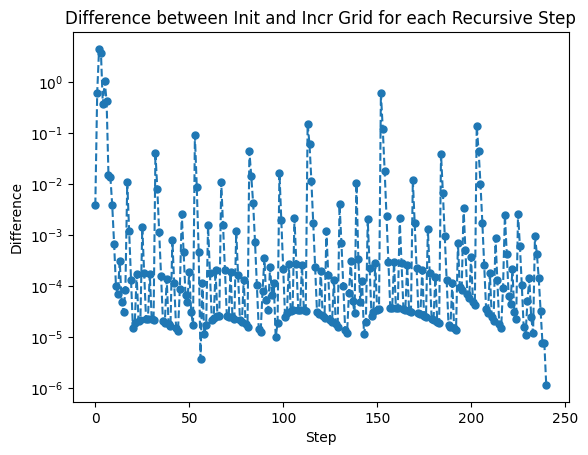

In [26]:
plt.title("Difference between Init and Incr Grid for each Recursive Step")
plt.xlabel("Step")
plt.ylabel("Difference")
plt.yscale('symlog', linthresh=1e-6)
plt.plot(global_diff_list, marker='o', linestyle='--', label='Difference value', markersize=5)

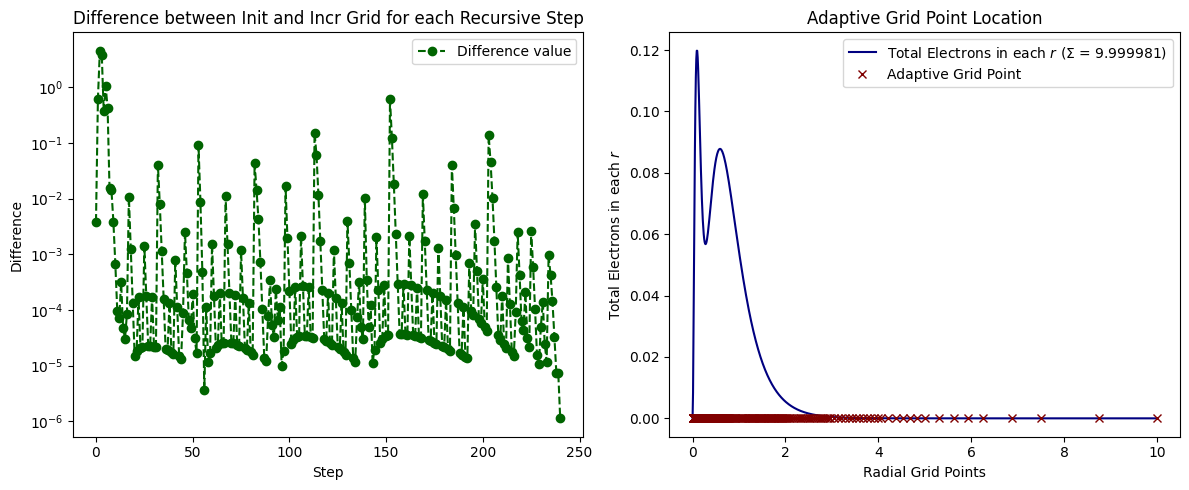

In [31]:

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
axes[0].plot(global_diff_list, marker='o', linestyle='--', label='Difference value', color='darkgreen')
axes[0].set_title("Difference between Init and Incr Grid for each Recursive Step")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Difference")
axes[0].set_yscale('symlog', linthresh=1e-6)
axes[0].legend()

# Second subplot
plt.plot(r_values, density_list, label=f'Total Electrons in each $r$ (Σ = {sum_e:.6f})', color='navy')
axes[1].plot(global_xc_list, np.repeat(0, len(global_xc_list)), 'x', markersize=6, label='Adaptive Grid Point', color='maroon')
axes[1].set_title("Adaptive Grid Point Location")
axes[1].set_xlabel("Radial Grid Points")
axes[1].set_ylabel("Total Electrons in each $r$")
axes[1].legend()
plt.tight_layout()

plt.savefig('adaptive_radial_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

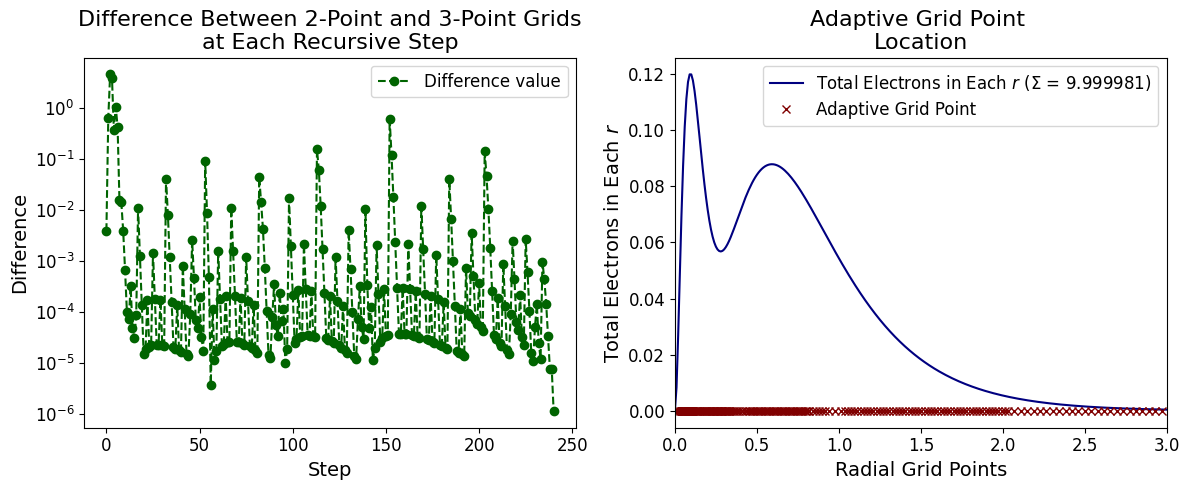

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
axes[0].plot(global_diff_list, marker='o', linestyle='--', label='Difference value', color='darkgreen')
axes[0].set_title("Difference Between 2-Point and 3-Point Grids\nat Each Recursive Step", fontsize=16)
axes[0].set_xlabel("Step", fontsize=14)
axes[0].set_ylabel("Difference", fontsize=14)
axes[0].set_yscale('symlog', linthresh=1e-6)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(fontsize=12)

# Second subplot
axes[1].plot(r_values, density_list, label=f'Total Electrons in Each $r$ (Σ = {sum_e:.6f})', color='navy')
axes[1].plot(global_xc_list, np.repeat(0, len(global_xc_list)), 'x', markersize=6, label='Adaptive Grid Point', color='maroon')
axes[1].set_title("Adaptive Grid Point \nLocation", fontsize=16)
axes[1].set_xlabel("Radial Grid Points", fontsize=14)
axes[1].set_ylabel("Total Electrons in Each $r$", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(fontsize=12)
axes[1].set_xlim(0, 3)

plt.tight_layout()
plt.savefig('adaptive_radial_angular_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()


https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Book%3A_Quantum_States_of_Atoms_and_Molecules_%28Zielinksi_et_al%29/09%3A_The_Electronic_States_of_the_Multielectron_Atoms/9.09%3A_Chemical_Applications_of_Atomic_Structure_Theory/9.9.9C%3A_9.9.9C%3A_Atomic_Sizes_and_Electron_Density_Distributions